In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

## Load the processed data

https://linkinghub.elsevier.com/retrieve/pii/S0092-8674(18)31164-4

Raw UMI counts of the resulting 1383 enterocytes and transientamplifying cells were exported and utilized for zonation reconstruction algorithm (https://zenodo.org/record/1320734 under thefiles table_B_scRNaseq_UMI_counts.tsv and table_C_scRNaseq_tsne_coordinates_zones.tsv).

In [4]:
from intestine_info import load_processed_enterocyte_data, get_intestine_rna_lm_genes
from intestine_info import load_original_entero_zonation

res_dir = "/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719"
obs_df, var_df, mtx = load_processed_enterocyte_data(res_dir)
zone_vals = load_original_entero_zonation(just_vals=True)
mtx.shape

[feat_viz INFO] {'Crypt': 0, 'V1': 1, 'V2': 2, 'V3': 3, 'V4': 4, 'V5': 5, 'V6': 6}


(1383, 9656)

In [5]:
mtx[:10,:10]

array([[-0.38641185, -0.09100008,  0.6829792 , -0.10100581, -0.22058721,
        -0.03523853, -0.16889207, -0.06395275, -0.16470033, -0.01175297],
       [-0.38641185,  0.8451616 , -0.22578803, -0.10100581, -0.22058721,
        -0.03523853,  1.1296158 , -0.06395275,  1.1338074 , -0.01175297],
       [-0.38641185,  0.15341419,  0.92739356, -0.10100581, -0.22058721,
        -0.03523853, -0.16889207, -0.06395275, -0.16470033, -0.01175297],
       [-0.38641185,  1.1722591 , -0.22578803, -0.10100581,  0.85918623,
        -0.03523853, -0.16889207, -0.06395275, -0.16470033, -0.01175297],
       [ 0.622611  , -0.37304866,  0.40093067, -0.10100581, -0.22058721,
        -0.03523853,  0.4578266 , -0.06395275, -0.16470033, -0.01175297],
       [-0.38641185, -0.99976736,  1.1218153 , -0.10100581, -0.22058721,
        -0.03523853, -0.16889207, -0.06395275, -0.16470033, -0.01175297],
       [-0.38641185,  0.84317786,  0.69791627,  0.46391103,  0.34432966,
         0.52967834, -0.16889207, -0.06395275

In [3]:
lm_genes = get_intestine_rna_lm_genes()
lm_genes = lm_genes["high"] + lm_genes["low"]
logger.info("Number of original lm genes: {}".format(len(lm_genes)))
lm_genes = list(set(lm_genes).intersection(set(var_df["gene_ids"])))
lm_genes = sorted(lm_genes)
logger.info("Number of intersecting lm genes: {}".format(len(lm_genes)))

[feat_viz INFO] Loaded 453 genes
[feat_viz INFO] Kept 243 genes with max expr > 0.001 
[feat_viz INFO] Kept 45 high zone genes with geom avg > 3.5 
[feat_viz INFO] Kept 64 low zone genes with geom avg < 2.5 
[feat_viz INFO] Number of original lm genes: 109
[feat_viz INFO] Number of intersecting lm genes: 97


In [8]:
from scrna_utils import get_gene_df
x_star_df = get_gene_df(lm_genes, var_df, mtx)

[feat_viz INFO] x_star_df dim: (1383, 97)


In [9]:
from main_methods import run_procedure, run_unsupervised, evaluate_result
RDIR = os.path.join(res_dir, "entero_data", "results")
params = {
    "method": None,
    "n_perms": 10000,
    "perm_method": "pool",
    "alpha": 0.05, 
    "graph_k": 10,
}

### Run purely unsupervised methods

In [10]:
for method in ["graph", "pc"]:
    params["method"] = method
    name = "unsup_{}".format(method)
    fn =  "lam_{}_unsupervised.plk".format(method)
    fn = os.path.join(RDIR, fn)
    result = run_unsupervised(x_star_df.values, mtx, params, fn=fn)

[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results/lam_graph_unsupervised.plk
[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results/lam_pc_unsupervised.plk


### Run our prescribed procedures

In [12]:
for method in ["pc", "graph", "hybrid"]:
    for mtype in ["vanilla", "oracle"]:
        if mtype == "oracle":
            lam_in = zone_vals
            continue
        else:
            lam_in = None
        params["method"] = method
        fn =  "result_{}_{}.plk".format(method, mtype)
        fn = os.path.join(RDIR, fn)
        result = run_procedure(x_star_df.values, mtx, params, lam_in=lam_in, fn=fn)
#         evaluate_result(result, lam_ref=zone_vals)

[feat_viz INFO] Running pc-based procedure
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting pc-based features...
[feat_viz INFO] Updated latent variables...
[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results/result_pc_vanilla.plk
[feat_viz INFO] Running graph-based procedure
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting graph-based features...
[feat_viz INFO] Updated latent variables...
[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results/result_graph_vanilla.plk
[feat_viz INFO] Running hybrid-based procedure
[feat_viz INFO] Inferred initial latent variables
[feat_viz INFO] Selecting hybrid-based features...
[feat_viz INFO] Updated latent variables...
[feat_viz INFO] Saving results to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results/result_hybrid_vanilla.plk


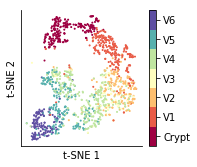

In [30]:
from intestine_info import load_enterocyte_meta_data
from plot_utils import plot_multi_scatter_discrete
cell_df = load_enterocyte_meta_data()
proj = cell_df[["tSNE_coordinate_1", "tSNE_coordinate_2"]]

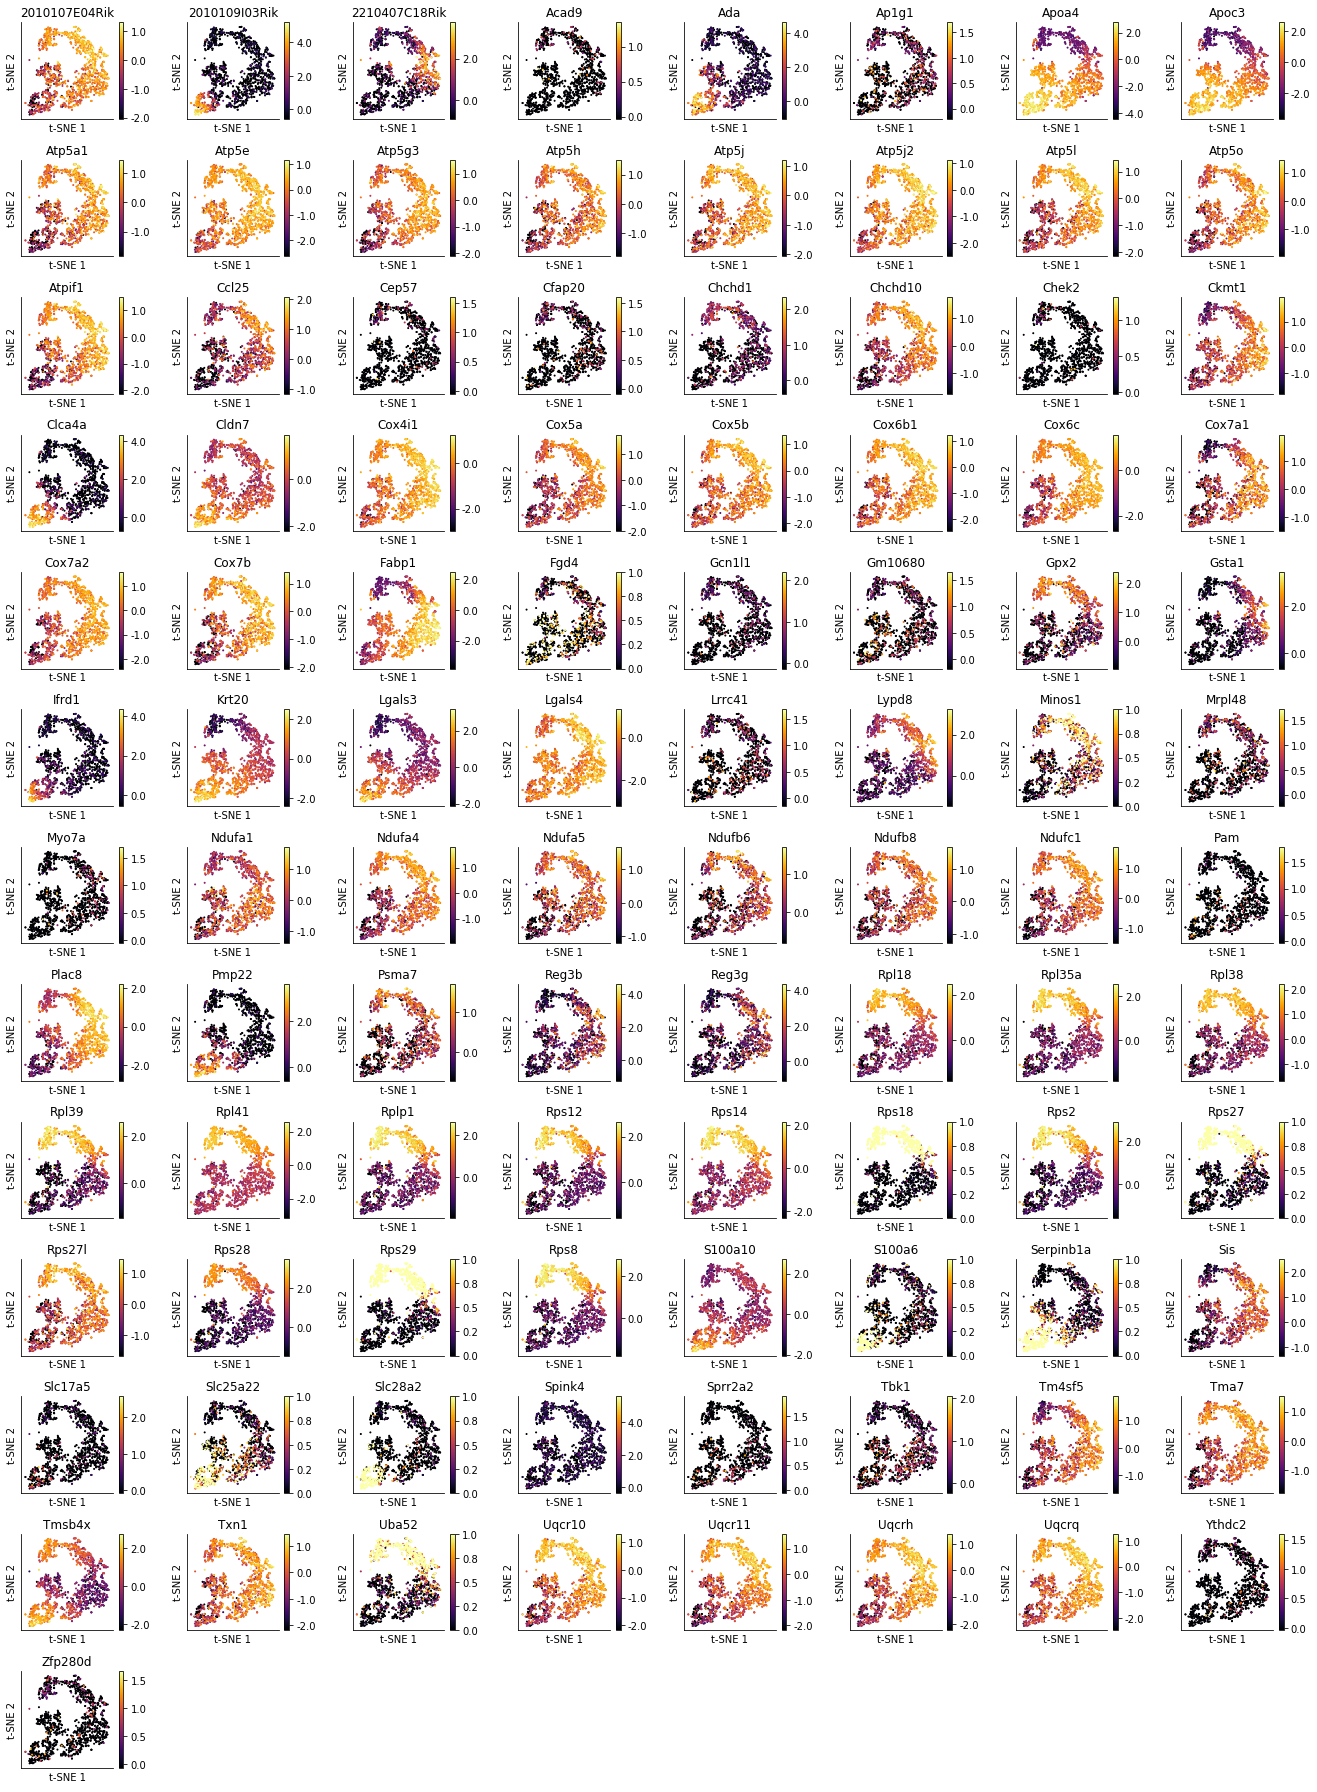

In [31]:
plot_multi_scatter_discrete(x_star_df, proj, logscale=False)